# Chapter 15

## Load packages / modules

Standard library:
- Printf for string formatting
- Statistics for mean and std functions
- Random for boostrap sampling

External:
- CSV.jl to load CSV files
- DataFrames.jl for tabular data
- CategoricalArrays.jl for working with categorical data columns and the `cut` function
- GLM.jl for models
- StatsBase.jl for histogram binning
- CairoMakie.jl for plotting

In [1]:
using Printf, Statistics, Random
using CSV, DataFrames, CategoricalArrays, GLM, StatsBase, CairoMakie

## Load data

In [2]:
nhefs_all = DataFrame(CSV.File("nhefs.csv"));

In [3]:
size(nhefs_all)

(1629, 64)

In [4]:
for s in [:education, :exercise, :active]
    nhefs_all[!, s] = categorical(nhefs_all[!, s])
end

Subset to uncensored rows

In [5]:
nhefs = dropmissing(nhefs_all, :wt82);

In [6]:
size(nhefs)

(1566, 64)

## Section 15.1

### Program 15.1

"Using the same model as in Section 13.2..."

In [7]:
spec = @formula(
    wt82_71 ~ qsmk
            + sex
            + race
            + education
            + exercise
            + active
            + age + age ^ 2
            + wt71 + wt71 ^ 2
            + smokeintensity + smokeintensity ^ 2
            + smokeyrs + smokeyrs ^ 2
            + qsmk & smokeintensity
);

In [8]:
ols = lm(spec, nhefs)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

wt82_71 ~ 1 + qsmk + sex + race + education + exercise + active + age + :(age ^ 2) + wt71 + :(wt71 ^ 2) + smokeintensity + :(smokeintensity ^ 2) + smokeyrs + :(smokeyrs ^ 2) + qsmk & smokeintensity

Coefficients:
─────────────────────────────────────────────────────────────────────────────────────────────
                              Coef.   Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
─────────────────────────────────────────────────────────────────────────────────────────────
(Intercept)            -1.58817      4.31304      -0.37    0.7128  -10.0482       6.87186
qsmk                    2.55959      0.809149      3.16    0.0016    0.972449     4.14674
sex                    -1.43027      0.468958     -3.05    0.0023   -2.35013     -0.510411
race                    0.56011      0.581889      0.96 

In [9]:
println("           estimate")
@printf "alpha_1     %6.2f\n" coef(ols)[2]
@printf "alpha_2     %6.2f" coef(ols)[end]

           estimate
alpha_1       2.56
alpha_2       0.05

To obtain the estimates of the effect of quitting smoking, we'll use a `t_test` on the fitted model

Software often provides a convenient way to calculate these, but here we'll use a more manual calculation. We create two arrays of values to represent to two situations we want to compare. We take the difference of arrays, and multiply by the coefficients above to get the estimate and mutiply with the covariance matrix to get the standard error.

In the current case, here are two options for the created arrays
1. Arrays with one value for each term in the regression. Use zeros for all terms except intercept, and terms involving `qsmk` and `smokeintensity`.
2. Use sub-arrays for just the terms of interest and use corresponding values in the estimated coefficient and covariance matrix.

We'll use the second approach.

First extract the values of the coefficents and covariance matrix

In [10]:
# intercept, qsmk, smokeintensity, smokeintensity^2, qsmk * smokeintensity
contrast_indices = [1, 2, 17, 18, 21]
sub_coef = coef(ols)[contrast_indices]
sub_vcov = vcov(ols)[contrast_indices, contrast_indices];

Now, for the 5 cigarettes/day example, we'll construct the constrast arrays and calculate the effect.

In [11]:
# intercept, qsmk, smokeintensity, smokeintensity^2, qsmk * smokeintensity
contrast_array1 = [1, 1, 5, 25, 5]  
contrast_array2 = [1, 0, 5, 25, 0]
contrast_diff = contrast_array1 .- contrast_array2;

In [12]:
est = sum(sub_coef .* contrast_diff)
ste = sqrt(contrast_diff' * sub_vcov * contrast_diff);

In [13]:
lo = (est - 1.96 * ste)
hi = (est + 1.96 * ste)

println("effect of quitting when smoking 5 cigarettes/day\n")
println("              estimate    95% C.I.")
@printf "qsmk effect   %6.1f     (%0.1f, %0.1f)\n" est lo hi

effect of quitting when smoking 5 cigarettes/day

              estimate    95% C.I.
qsmk effect      2.8     (1.5, 4.1)


<br>
Now we'll do the same for 40 cigarettes/day.

In [14]:
# intercept, qsmk, smokeintensity, smokeintensity^2, qsmk * smokeintensity
contrast_array1 = [1, 1, 40, 1600, 40]  
contrast_array2 = [1, 0, 40, 1600,  0]
contrast_diff = contrast_array1 .- contrast_array2;

In [15]:
est = sum(sub_coef .* contrast_diff)
ste = sqrt(contrast_diff' * sub_vcov * contrast_diff);

In [16]:
lo = (est - 1.96 * ste)
hi = (est + 1.96 * ste)

println("effect of quitting when smoking 40 cigarettes/day\n")
println("              estimate    95% C.I.")
@printf "qsmk effect   %6.1f     (%0.1f, %0.1f)\n" est lo hi

effect of quitting when smoking 40 cigarettes/day

              estimate    95% C.I.
qsmk effect      4.4     (2.8, 6.1)


<br>
If we don't use the product term `qsmk & smokeintensity`, we get the following model and effect estimate

In [17]:
spec = @formula(
    wt82_71 ~ qsmk
            + sex
            + race
            + education
            + exercise
            + active
            + age + age ^ 2
            + wt71 + wt71 ^ 2
            + smokeintensity + smokeintensity ^ 2
            + smokeyrs + smokeyrs ^ 2
);

In [18]:
ols = lm(spec, nhefs)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

wt82_71 ~ 1 + qsmk + sex + race + education + exercise + active + age + :(age ^ 2) + wt71 + :(wt71 ^ 2) + smokeintensity + :(smokeintensity ^ 2) + smokeyrs + :(smokeyrs ^ 2)

Coefficients:
──────────────────────────────────────────────────────────────────────────────────────────
                           Coef.   Std. Error      t  Pr(>|t|)     Lower 95%     Upper 95%
──────────────────────────────────────────────────────────────────────────────────────────
(Intercept)         -1.65862      4.31377      -0.38    0.7007  -10.1201       6.80285
qsmk                 3.46262      0.438454      7.90    <1e-14    2.60259      4.32265
sex                 -1.46505      0.468341     -3.13    0.0018   -2.3837      -0.546399
race                 0.586412     0.581695      1.01    0.3136   -0.554583     1.72741
education: 

In [19]:
est = coef(ols)[2]
lo, hi = confint(ols)[2, 1], confint(ols)[2, 2]

println("           estimate   95% C.I.")
@printf "alpha_1     %5.1f    (%0.1f, %0.1f)" est lo hi

           estimate   95% C.I.
alpha_1       3.5    (2.6, 4.3)

## Section 15.2

### Program 15.2

To estimate propensity score, we fit a logistic model for `qsmk` conditional on $L$

In [20]:
spec = @formula(
    qsmk ~ sex
         + race
         + age + age ^ 2
         + education
         + smokeintensity + smokeintensity ^ 2
         + smokeyrs + smokeyrs ^ 2
         + exercise
         + active
         + wt71 + wt71 ^ 2
)

model = glm(spec, nhefs_all, Binomial(), LogitLink());

Then propensity is the predicted values

In [21]:
propensity = predict(model, nhefs_all)
nhefs_all.propensity = propensity;

The lowest and highest propensity scores:

In [22]:
ranked = sort(nhefs_all[!, [:seqn, :propensity]], :propensity);

In [23]:
ranked[1, :]

,seqn,propensity
,Int64,Float64?
1,22941,0.0529808


In [24]:
ranked[end, :]

,seqn,propensity
,Int64,Float64?
1629,24949,0.793205


Now we'll attempt to recreate Figure 15.1, pg 45

First, we'll split the propensities based on whether the subject quit smoking

In [25]:
propensity0 = propensity[nhefs_all.qsmk .== 0]
propensity1 = propensity[nhefs_all.qsmk .== 1];

It looks like the bins are spaced every 0.05 (except at the right end), with the first bin starting at 0.025.

In [26]:
bins = collect(0.025:0.05:0.85)
top0 = fit(Histogram, propensity0, bins)
top1 = fit(Histogram, propensity1, bins);

In [27]:
xpos = bins[1:end-1] .+ 0.025;

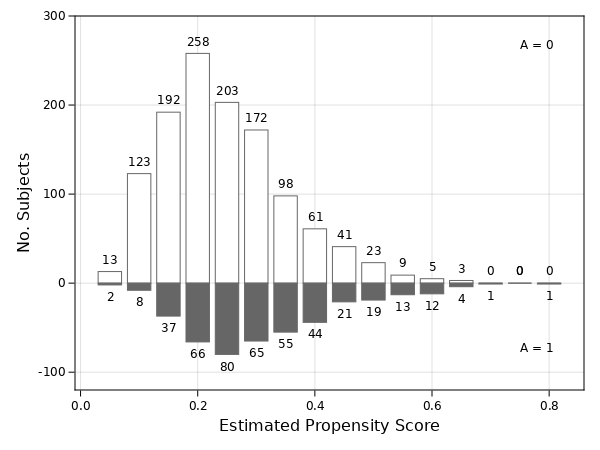

In [28]:
fig = Figure(resolution=(600, 450)) 
ax = Axis(
    fig[1, 1],
    xlabel="Estimated Propensity Score",
    ylabel="No. Subjects",
    xticklabelsize=12,
    yticklabelsize=12
)

barplot!(
    ax,
    xpos,
    top0.weights,
    color=:white,
    strokecolor=:gray40,
    strokewidth=1,
    bar_labels=:y,
    label_size=12,
    label_formatter=(y -> string(Int(y)))
)

barplot!(
    ax,
    xpos,
    (-1 .* top1.weights),
    color=:gray40,
    strokecolor=:gray40,
    strokewidth=1,
    bar_labels=:y,
    label_size=12,
    label_formatter=(y -> string(Int(-y)))
)

text!(
    ax,
    ["A = 0", "A = 1"],
    position=[(0.75, 260), (0.75, -80)],
    textsize=12,
)

ylims!(ax, -120, 300)

fig

In [29]:
println("                  mean propensity")
@printf "    non-quitters: %0.3f\n" mean(propensity0)
@printf "        quitters: %0.3f" mean(propensity1)

                  mean propensity
    non-quitters: 0.245
        quitters: 0.312

## Section 15.3

### Program 15.3

"only individual 22005 had an estimated $\pi(L)$ of 0.6563", pg 186

In [30]:
nhefs_all[abs.(propensity .- 0.6563) .< 1e-4, [:seqn, :propensity]]

,seqn,propensity
,Int64,Float64?
1,22005,0.656281


Create the deciles and check their counts

In [31]:
nhefs_all.decile = cut(propensity, 10, labels=["$i" for i in 1:10]);

In [32]:
# count number in each decile
combine(groupby(nhefs_all, :decile), nrow)

,decile,nrow
,Cat…?,Int64
1,1,163
2,2,163
3,3,163
4,4,163
5,5,162
6,6,163
7,7,163
8,8,163
9,9,163


Now create a model with interaction between `qsmk` and deciles of $\pi(L)$

In [33]:
model = lm(@formula(wt82_71 ~ qsmk * decile), nhefs_all)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

wt82_71 ~ 1 + qsmk + decile + qsmk & decile

Coefficients:
─────────────────────────────────────────────────────────────────────────────────
                        Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
─────────────────────────────────────────────────────────────────────────────────
(Intercept)         3.9952       0.630308   6.34    <1e-09   2.75886    5.23155
qsmk               -0.0146537    2.38883   -0.01    0.9951  -4.70034    4.67103
decile: 2          -1.09053      0.916364  -1.19    0.2342  -2.88797    0.706921
decile: 3          -1.38311      0.918205  -1.51    0.1322  -3.18417    0.417948
decile: 4          -0.520526     0.925819  -0.56    0.5740  -2.33652    1.29547
decile: 5          -1.88542      0.942367  -2.00    0.0456  -3.73387   -0.0369653
decile: 6          -2.15738      

To get the effect estimates, we'll calculate contrasts, like we did in Program 15.1

In [34]:
# extract model coefficients and covariance matrix
betas = reshape(coef(model), 20, 1)
beta_cov = vcov(model)

# create contrast arrays
c1 = cat([1, 1], zeros(18), dims=1)    # for qsmk=1
c2 = cat([1, 0], zeros(18), dims=1)    # for qsmk=0

# loop through tests, modify c1 and c2 for each decile,
# and print out effect estimate and confidence interval
println("           estimate    95% C.I.\n")
for i in 1:10
    if i != 1
        # set the decile number
        c1[i + 1] = 1     # qsmk=1: set decile
        c1[i + 10] = 1    # qsmk=1: set qsmk & decile term
        c2[i + 1] = 1     # qsmk=0: set decile
    end
    
    cdiff = reshape(c1 .- c2, 20, 1)

    est = cdiff' * betas
    ste = sqrt(cdiff' * beta_cov * cdiff)
    lo = est - 1.96 * ste
    hi = est + 1.96 * ste

    @printf "decile %2d    %5.1f    (%4.1f,%4.1f)\n" i est[1] lo[1] hi[1]
    
    if i != 1
        # reset to zero
        c1[i + 1] = 0
        c1[i + 10] = 0
        c2[i + 1] = 0
    end
end

println("\n(using normal approximation)\n")

           estimate    95% C.I.

decile  1     -0.0    (-4.7, 4.7)
decile  2      4.1    ( 0.9, 7.4)
decile  3      6.5    ( 3.4, 9.7)
decile  4      2.3    (-0.5, 5.2)
decile  5      4.1    ( 1.4, 6.8)
decile  6      4.6    ( 1.9, 7.3)
decile  7      4.3    ( 1.5, 7.1)
decile  8      3.6    ( 0.9, 6.2)
decile  9      2.3    (-0.2, 4.8)
decile 10      2.2    (-0.2, 4.7)

(using normal approximation)



We can compare the estimates above to the estimate we get from a model without interaction between `qsmk` and deciles of $\pi(L)$

In [35]:
model = lm(@formula(wt82_71 ~ qsmk + decile), nhefs_all)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

wt82_71 ~ 1 + qsmk + decile

Coefficients:
──────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────────────
(Intercept)   3.75049     0.608914   6.16    <1e-09    2.55611   4.94487
qsmk          3.50039     0.457059   7.66    <1e-13    2.60387   4.3969
decile: 2    -0.739116    0.861052  -0.86    0.3908   -2.42806   0.94983
decile: 3    -0.6182      0.861203  -0.72    0.4730   -2.30744   1.07104
decile: 4    -0.520373    0.858385  -0.61    0.5445   -2.20409   1.16334
decile: 5    -1.47923     0.860395  -1.72    0.0858   -3.16688   0.208429
decile: 6    -1.6312      0.866063  -1.88    0.0598   -3.32997   0.0675734
decile: 7    -1.98525     0.868104  -2.29

In [36]:
est = coef(model)[2]
lo, hi = confint(model)[2, 1], confint(model)[2, 2]

println("         estimate   95% C.I.")
@printf "effect    %5.1f    (%0.1f, %0.1f)" est lo hi

         estimate   95% C.I.
effect      3.5    (2.6, 4.4)

### Program 15.4

Now we will do "outcome regression $\mathrm{E}[Y|A, C=0, p(L)]$ with the estimated propensity score $\pi(L)$ as a continuous covariate rather than as a set of indicators" (pg 187)

In [37]:
nhefs.propensity = propensity[.! ismissing.(nhefs_all.wt82_71)];

In [38]:
model = lm(@formula(wt82_71 ~ qsmk + propensity), nhefs)

StatsModels.TableRegressionModel{LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, LinearAlgebra.CholeskyPivoted{Float64, Matrix{Float64}}}}, Matrix{Float64}}

wt82_71 ~ 1 + qsmk + propensity

Coefficients:
─────────────────────────────────────────────────────────────────────────
                 Coef.  Std. Error      t  Pr(>|t|)  Lower 95%  Upper 95%
─────────────────────────────────────────────────────────────────────────
(Intercept)    5.59449    0.483076  11.58    <1e-29    4.64694    6.54204
qsmk           3.5506     0.45726    7.76    <1e-13    2.65369    4.4475
propensity   -14.8218     1.75758   -8.43    <1e-16  -18.2693   -11.3744
─────────────────────────────────────────────────────────────────────────

From the coefficient on `qsmk` we can see the effect estimate is 3.6.

We'll use bootstrap to get confidence intervals.

In [39]:
function outcome_regress_effect(data::DataFrame)
    model = lm(@formula(wt82_71 ~ qsmk + propensity), data)
    
    data_qsmk_1 = copy(data)
    data_qsmk_1.qsmk .= 1
    
    data_qsmk_0 = copy(data)
    data_qsmk_0.qsmk .= 0
    
    mean_qsmk_1 = mean(predict(model, data_qsmk_1))
    mean_qsmk_0 = mean(predict(model, data_qsmk_0))
    
    return mean_qsmk_1 - mean_qsmk_0
end;

In [40]:
function nonparametric_bootstrap(data, func; num_samples=1000)
    estimate = func(data)
    
    b_values = zeros(num_samples)
    for i in 1:num_samples
        rand_indices = rand(1:nrow(data), nrow(data))
        sample_data = data[rand_indices, :]
        b_values[i] = func(sample_data)
    end

    std_val = std(b_values)

    return estimate, (estimate - 1.96 * std_val, estimate + 1.96 * std_val)
end;

In [41]:
data = nhefs[!, [:wt82_71, :qsmk, :propensity]]

info = nonparametric_bootstrap(data, outcome_regress_effect, num_samples=2000)

(3.550595855838712, (2.59021228973868, 4.510979421938744))

In [42]:
println("         estimate   95% C.I.")
@printf "effect    %5.1f    (%0.1f, %0.1f)" info[1] info[2][1] info[2][2]

         estimate   95% C.I.
effect      3.6    (2.6, 4.5)